# **Sentiment and Topic Analysis of Trump's 2024 Campaign Speeches**

---
This project aims to analyze the speeches delivered by [Donald Trump during his 2024 campaign](https://www.kaggle.com/datasets/perceptron90/donald-trump-2024-transcripts) across various states. The analysis focuses on sentiment detection and topic categorization, highlighting trends in campaign rhetoric and public messaging. The speeches are categorized into key campaign topics, including Gun Laws, Climate, Crime, Healthcare, Taxes, Ukraine Aid, Abortion, Immigration, and Economy.

By leveraging advanced text mining and natural language processing (NLP) techniques, the project provides insights into:
- Sentiment trends across states and topics.
- Speech patterns and campaign strategies tailored to specific regions.
- Key themes and topics emphasized in the campaign.

## **Table of Contents**:
1. [Project Objectives](#project-objectives)  
2. [Data Collection](#data-collection)  
3. [Data Preprocessing](#data-preprocessing)  
4. [Sentiment Analysis](#sentiment-analysis)  
5. [LDA](#lda)  
6. [Predefined Topic Modeling](#predefined-topic-modeling)  
7. [Bert Topic Modeling](#bert-topic-modeling)  
8. [Kmeans Clustering](#kmeans-clustering)  
9. [Network Graphs](#network-graphs)  

---

### **1. Project Objectives**
- Perform sentiment analysis on the campaign speeches.  
- Categorize speech content into predefined topics.  
- Explore trends in sentiment and topics across states and over time.  
- Provide visualizations and insights for deeper understanding.

---

### **2. Data Collection**
- **Source**: Transcripts of speeches delivered by Trump in 2024 during his campaign events.  
- **Metadata**: Information about the speech's location (state), date, and associated campaign topics.  
- **Data Format**: Cleaned text data with associated metadata in a CSV format.

---

### **3. Methodology**
1. **Preprocessing**:
    - Text cleaning: Removing stopwords, special characters, and URLs.  
    - Tokenization and normalization: Breaking text into tokens and converting them to a standard format.  

2. **Sentiment Analysis**:
    - Use pre-trained sentiment analysis models like VADER.  
    - Categorize sentiments as Positive, Neutral, or Negative.

3. **Topic Categorization**:
    - Supervised classification for predefined topics.
    - Unsupervised topic modeling (e.g., LDA, BERTopic) to detect hidden themes.  

4. **Exploratory Data Analysis (EDA)**:
    - Analyze and visualize sentiment and topic trends over time and across states.  
    - Generate word clouds and N-gram analyses for insights.

5. **Text Clustering**:
    - Group similar speeches using clustering algorithms like KMeans and visualize them.


## Import libraries

In [ ]:
!pip install contractions bertopic vaderSentiment sentence-transformers networkx ipysigma
!pip install nltk==3.9
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py ipysigma

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import os
import json
import time
import networkx as nx
import contractions
import nltk

# download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from ipysigma import Sigma
from itertools import combinations
from collections import Counter

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# [2. Data Collection](#data-collection)

In [6]:
# collect all the file names in the directory
directory_path = 'text'

file_names = []

for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory_path, filename)
        file_names.append(filename)

In [7]:
# directory containing .txt files
directory = 'text'


# function to extract information
def extract_info(filename):
    filename1 = filename
    
    # remove some words from the filename
    for word in ['speak', 'speaks', 'holds', 'deliver', 'former', 'takes', 'delivers']:
        filename = filename.replace(word, "")
    

    # extract date
    date_match = re.search(r"(\d{8})", filename)
    date = date_match.group(1) if date_match else "Unknown"
    date = pd.to_datetime(date, format="%Y%m%d", errors="coerce").strftime("%Y-%m-%d")
    # extract location
    location_match = re.search(r"in-([a-z\-]+)(?:\.|_|\-)", filename)
    location_match1 = re.search(r"at-([a-z\-]+)(?:\.|_|\-)", filename)
    if location_match:
        location = location_match.group(1).replace("-", " ").title() 
    elif location_match1: 
        location = location_match1.group(1).replace("-", " ").title()
    else:
        location = "Unknown"
    
    location = location.replace('Transcript', '') if 'Transcript' in location else location
    location = location.replace('Rally', '') if 'Rally' in location else location
    location = location.strip()

    # Extract speaker
    speaker = "Donald Trump" if "trump" in filename.lower() or "donald-trump" in filename.lower() else "Unknown"

    if "vance-and-trump" in filename.lower():
        speaker = "Donald Trump and J.D. Vance"
    
    # extract title
    title_match = re.search(r"(rally|town-hall|speech|address|interview)", filename.lower())
    title = title_match.group(1).replace("-", " ").title() if title_match else "Unknown"
    
    # extract speech content
    file_path = os.path.join(directory, filename1)
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            speech = file.read()
    except FileNotFoundError:
        speech = "File not found"
    except Exception as e:
        speech = f"Error reading file: {e}"
    
    return {
        "date": date,
        "location": location,
        "deliverer": speaker,
        "title": title,
        "speech": speech
    }

# process all filenames
speech_data = [extract_info(name) for name in file_names]
speech_df = pd.DataFrame(speech_data).sort_values(by="date").reset_index(drop=True)
speech_df.to_csv("speech_data.csv", index=False)


In [8]:
speech_df = pd.read_csv("speech_data.csv")
speech_df['date'] = pd.to_datetime(speech_df['date'])

speech_df

,date,location,deliverer,title,speech
0,2022-11-07,Pa For Dr Oz,Donald Trump,Rally,\nYou’re going to elect Dr. Mehmet Oz to the U...
1,2022-11-16,Unknown,Donald Trump,Unknown,"\nWell, thank you very much, and on behalf of ..."
2,2023-02-01,New York Attorney Generals Fraud Investigation,Donald Trump,Unknown,\nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...
3,2023-03-06,Cpac,Donald Trump,Unknown,"\nWell, thank you very much and I’m thrilled t..."
4,2023-03-14,Davenport Iowa,Donald Trump,Speech,"\nOh, thank you very much. Thank you very much..."
...,...,...,...,...,...
94,2024-10-24,Greensboro North Carolina,Donald Trump,Rally,\nThank you.(26:51)Remember when I said no tax...
95,2024-10-28,Novi Michigan,Donald Trump,Rally,"\nWhen I’m re-elected, I will totally oblitera..."
96,2024-10-28,State College Pennsylvania,Donald Trump,Rally,"\nWow.\n\n\nWell, thank you very much. This is..."
97,2024-10-28,Unknown,Donald Trump,Interview,\nLet’s go.\n\n\nSure.\n\n\nThat’s right.\n\n\...


# Data Preprocessing

The first round of the 2024 U.S. presidential election primaries began on January 15, 2024, with the Iowa caucuses, followed by the New Hampshire primary. So I use data starting from 2024-01-01.

In [49]:
# Load the dataset
df = speech_df[speech_df.date >= '2024-01-01'].copy()
df = df.sort_values(by=['date']).reset_index(drop=True)

# initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# clean a single speech
def clean_speech(speech):
    
    # apply contractions
    speech = contractions.fix(speech)
    
    # remove speaker labels, timestamps, and non-alphanumeric characters
    speech = re.sub(r"\d2:\d2\d{2}:\d{2}", "", speech)  # remove timestamps
    speech = re.sub(r"[^\w\s]", " ", speech)         # remove punctuation
    speech = re.sub(r"\s+", " ", speech)             # remove extra spaces
    
    # convert to lowercase
    speech = speech.lower()
    
    # tokenize into sentences
    sentences = sent_tokenize(speech)
    
    # tokenize words, remove stopwords, and lemmatize
    cleaned_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        cleaned_sentences.append(" ".join(tokens))
    
    return " ".join(cleaned_sentences)

# apply the cleaning 
df['cleaned_speech'] = df['speech'].apply(clean_speech)

df

,date,location,deliverer,title,speech,cleaned_speech
0,2024-01-08,Sioux Center Iowa,Donald Trump,Rally,\nThank you very much. We’re going to take our...,thank much going take country back going take ...
1,2024-01-22,Rochester New Hampshire,Donald Trump,Unknown,"\nThank you. Thank you. Wow, what a crowd. You...",thank thank wow crowd got lot people standing ...
2,2024-01-29,Las Vegas,Donald Trump,Rally,\nThank you very much. Thank you. Thank you.\n...,thank much thank thank thank much thank know o...
3,2024-02-01,Unknown,Donald Trump,Unknown,"\nWell, thank you very much. We had a very str...",well thank much strong meeting teamster year e...
4,2024-02-12,South Carolina,Donald Trump,Speech,"\nWell, thank you very much, South Carolina. W...",well thank much south carolina great relations...
...,...,...,...,...,...,...
68,2024-10-24,Greensboro North Carolina,Donald Trump,Rally,\nThank you.(26:51)Remember when I said no tax...,thank 26 51 remember said tax tip like month l...
69,2024-10-28,Novi Michigan,Donald Trump,Rally,"\nWhen I’m re-elected, I will totally oblitera...",elected totally obliterate deep state long pri...
70,2024-10-28,State College Pennsylvania,Donald Trump,Rally,"\nWow.\n\n\nWell, thank you very much. This is...",wow well thank much quite gathering getting en...
71,2024-10-28,Unknown,Donald Trump,Interview,\nLet’s go.\n\n\nSure.\n\n\nThat’s right.\n\n\...,let u go sure right yeah last week one last sh...


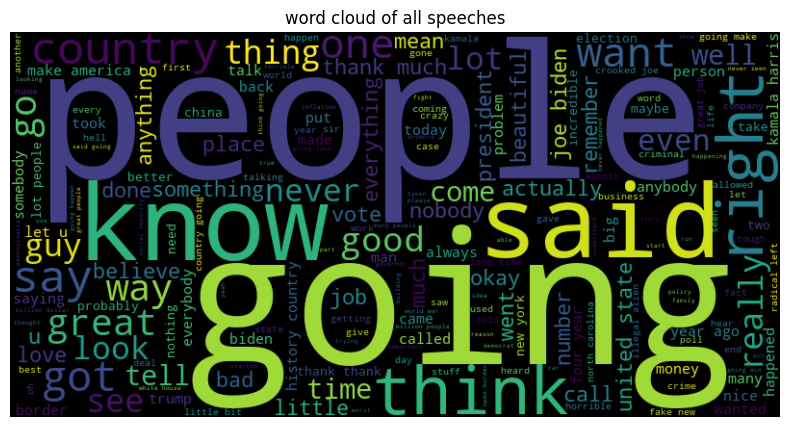

In [50]:
# generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800, 
						height=400,
						stopwords=set(STOPWORDS), 
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


cloud_text = df['cleaned_speech'].tolist()
generate_wordcloud(cloud_text,'word cloud of all speeches')

### Word Cloud Analysis Conclusion

The word cloud generated from the cleaned speeches provides a visual representation of the most frequently used words in Donald Trump's 2024 campaign speeches. The larger and bolder words indicate higher frequency and prominence in the speeches. 

Key observations from the word cloud:
- The most prominent words reflect the core themes and topics emphasized in the campaign.
- Commonly used words such as "America", "people", "great", and "country" highlight the patriotic and nationalistic tone of the speeches.
- The presence of words related to key campaign issues, such as "economy", "tax", "healthcare", and "immigration", indicates the focus areas of the campaign rhetoric.

Overall, the word cloud provides a quick and intuitive understanding of the primary topics and sentiments conveyed in the campaign speeches.

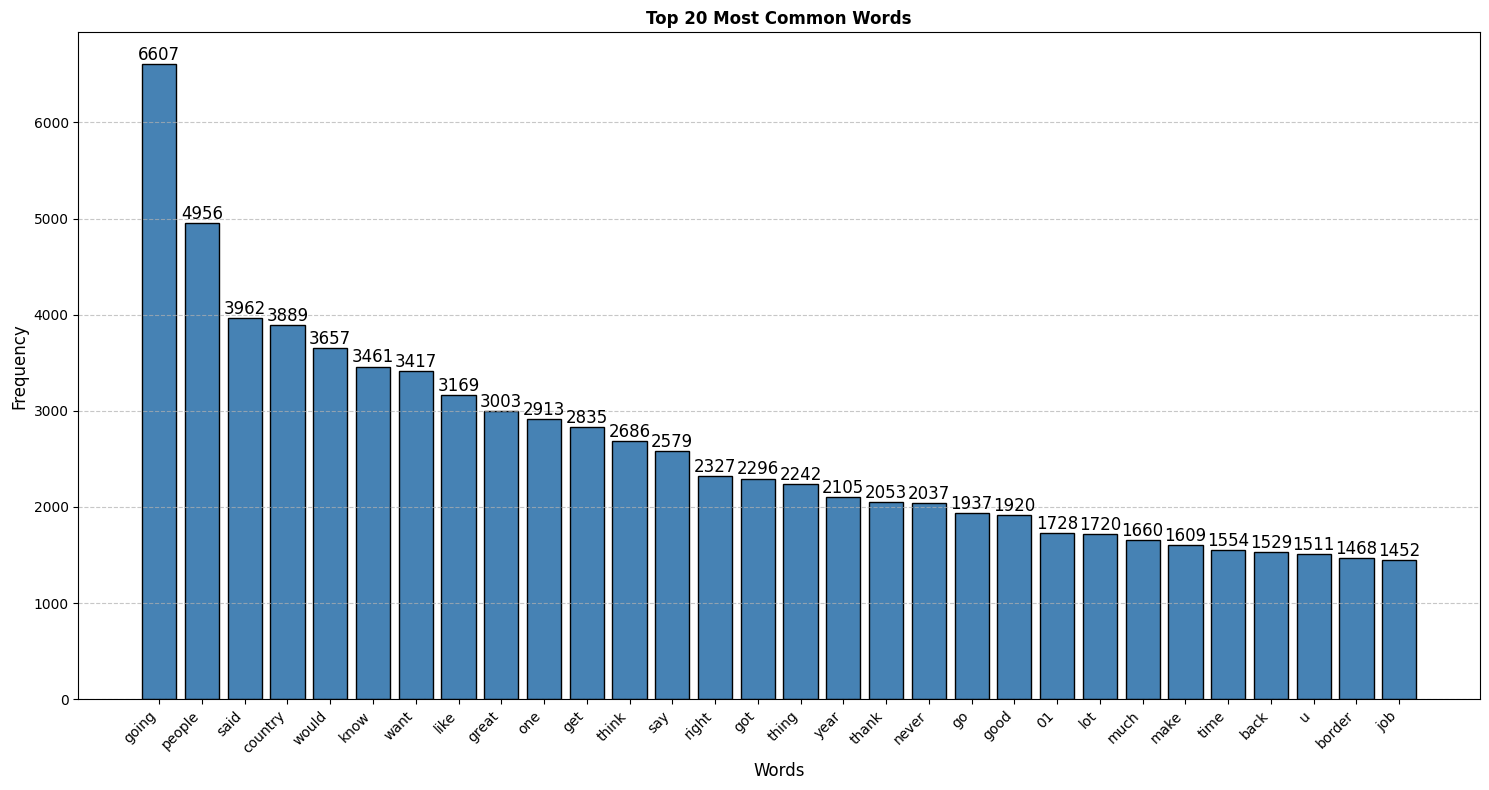

In [51]:
all_words = ' '.join(df['cleaned_speech']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

plt.figure(figsize=(15, 8))
bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

plt.title('Top 20 Most Common Words', fontsize=12, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [52]:
# delete the most common words 
top_15_words = [word for word, count in word_freq.most_common(15)]

def remove_top_words(text, top_words):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in top_words]
    return " ".join(filtered_tokens)

df['cleaned_speech'] = df['cleaned_speech'].apply(lambda x: remove_top_words(x, top_15_words))

In [53]:
# Tokenization
df['tokens'] = df['cleaned_speech'].apply(word_tokenize)

# Define stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df['tokens_no_stopwords'] = df['tokens'].apply(remove_stopwords)

In [54]:

# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['lemmatized_tokens'] = df['tokens_no_stopwords'].apply(lemmatize_tokens)

# combine tokens back to string for vectorization
df['processed_speech'] = df['lemmatized_tokens'].apply(lambda x: " ".join(x))

df.head(3)

,date,location,deliverer,title,speech,cleaned_speech,tokens,tokens_no_stopwords,lemmatized_tokens,processed_speech
0,2024-01-08,Sioux Center Iowa,Donald Trump,Rally,\nThank you very much. We’re going to take our...,thank much take back take back take back sad s...,"[thank, much, take, back, take, back, take, ba...","[thank, much, take, back, take, back, take, ba...","[thank, much, take, back, take, back, take, ba...",thank much take back take back take back sad s...
1,2024-01-22,Rochester New Hampshire,Donald Trump,Unknown,"\nThank you. Thank you. Wow, what a crowd. You...",thank thank wow crowd lot standing outside let...,"[thank, thank, wow, crowd, lot, standing, outs...","[thank, thank, wow, crowd, lot, standing, outs...","[thank, thank, wow, crowd, lot, standing, outs...",thank thank wow crowd lot standing outside let...
2,2024-01-29,Las Vegas,Donald Trump,Rally,\nThank you very much. Thank you. Thank you.\n...,thank much thank thank thank much thank outsid...,"[thank, much, thank, thank, thank, much, thank...","[thank, much, thank, thank, thank, much, thank...","[thank, much, thank, thank, thank, much, thank...",thank much thank thank thank much thank outsid...


# Sentiment Analysis

In [55]:
# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.5:
     return 'positive'
    elif sentiment_score['compound'] < -0.5:
     return 'negative'
    else:
     return 'neutral'

df['sentiment'] = df['cleaned_speech'].apply(get_sentiment)

In [93]:
px.bar(df, x='date', color='sentiment', title='Sentiment Distribution of Speeches',
       width=1000, height=800)

In [57]:
# count the number of speeches per location and sentiment
location_sentiment_count = df.groupby(['location', 'date', 'sentiment', 'deliverer', 'title']).size().reset_index(name='count')

# bubble chart
fig = px.scatter(location_sentiment_count, 
                 x='date', 
                 y='location', 
                 size='count', 
                 color='sentiment', 
                 hover_name='deliverer', 
                 hover_data={'title': True, 'count': True},
                 title='Bubble Chart of Speeches by Location and Sentiment')

fig.update_layout(showlegend=True, legend_title_text='Sentiment', width=1000, height=800)

fig.show()

Conclusion on Sentiment Distribution of Speeches

The sentiment analysis of Donald Trump's 2024 campaign speeches reveals insightful trends in the emotional tone conveyed throughout the campaign. By categorizing the speeches into positive, neutral, and negative sentiments, we can draw several conclusions:

There are many negative speeches delivered by the Trump campaign or during interviews in September and October. Also, we can see he was very active at the end of October because of the upcoming election. That's why his positive speeches increased a lot at the beginning of November. His speeches were mainly in Detroit, Chicago, and Michigan, while he held fewer speeches in Arizona and Ohio.

Additionally, his only two neutral speeches appeared in Florida and Philadelphia.

# LDA

In [58]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_speech'])

# Latent Dirichlet Allocation (LDA) for topic modeling
numberOftopics = 15
lda = LatentDirichletAllocation(n_components = numberOftopics, random_state=42)
lda_matrix = lda.fit(tfidf_matrix)

# print the top words for each topic
n_top_words = 20
words = tfidf_vectorizer.get_feature_names_out()
topic_keywords = {}

for topic_idx, topic in enumerate(lda.components_):
    topic_keywords[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {' '.join(topic_keywords[f'Topic {topic_idx}'])}")
    print()
    

Topic 0: brian rigged jim legal furniture catholic remain laken test bruce fani convicted value iraq sending devastated springfield machine door franklin

Topic 1: libertarian nominate sentenced regard skyrocket required neocon crony equity freer stake inclusion grip beloved guidance hateful 77 treaty expensing impartial

Topic 2: robin vow russo survivor kaplan bond understanding escaped humanity intend agony mourn balart heading impacted garcia ileana perez toxic directly

Topic 3: eviscerated gambling journalist officially statute 114 ronnie material lion cardinal 635 chevrolets cooking convicted abuse test sarah zoom libertarian heal

Topic 4: testify disclosure appealing fixer discussion appeal column 114 productive employed pled manufacture marked negotiating courthouse falsification maker cleaned material weekend

Topic 5: cardinal beech salt remembers vogue healthier distinguished install ambition insulted attend invitation suspect exchange blessed carve vulnerable brings mate 

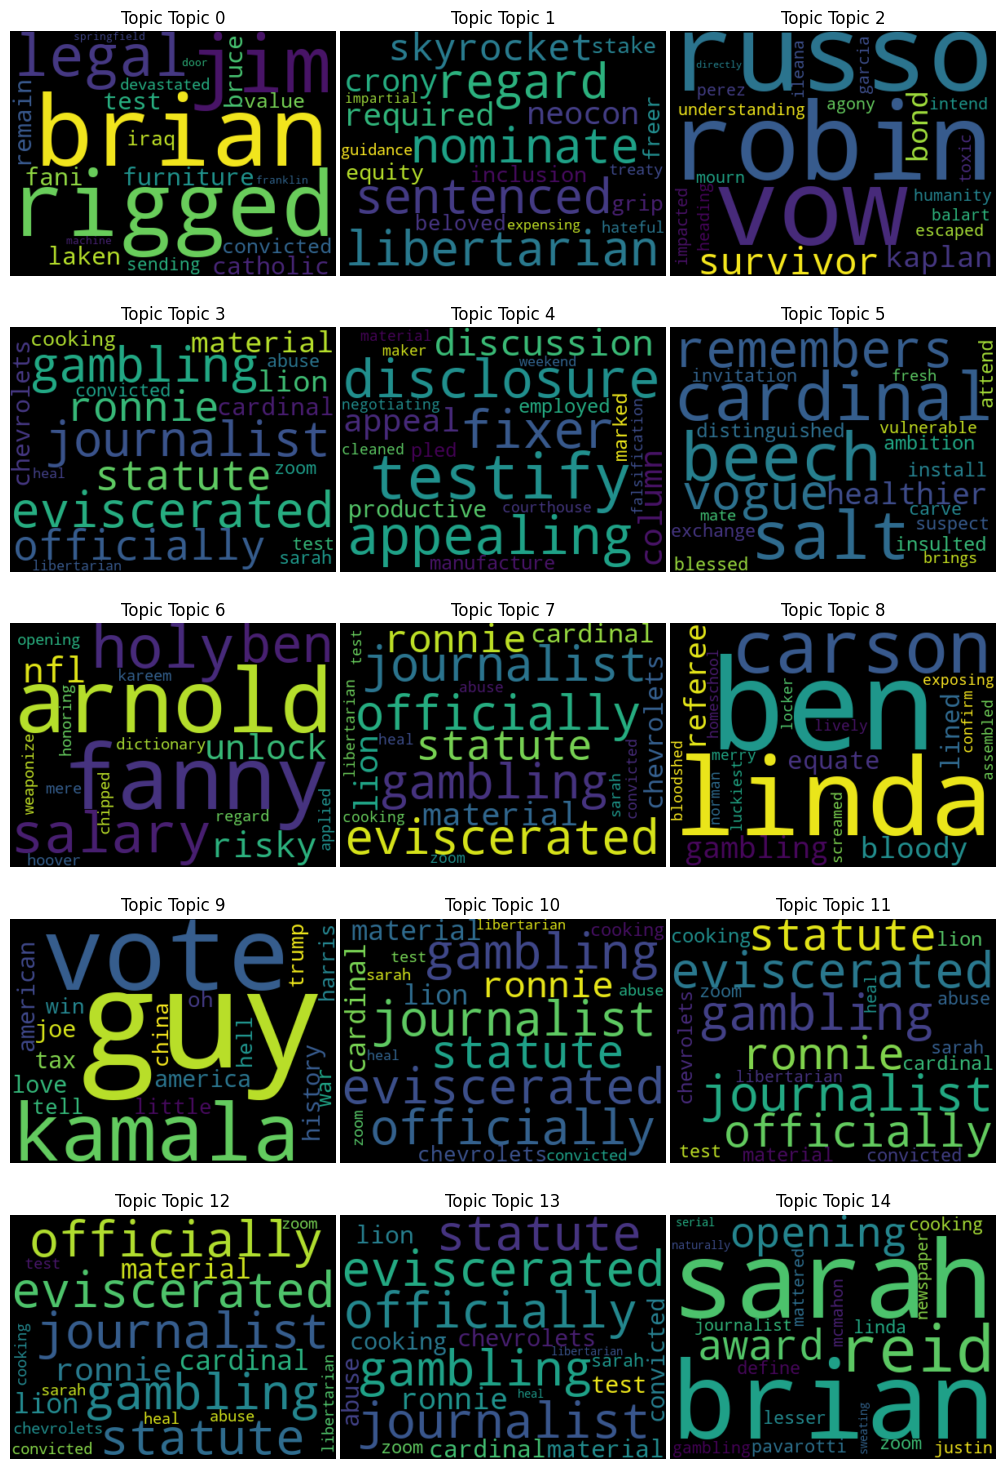

In [59]:
def plot_word_clouds_subplots(topic_keywords):
    num_topics = len(topic_keywords)
    fig, axes = plt.subplots(nrows=(num_topics // 3) + (num_topics % 3), ncols=3, figsize=(10, num_topics))
    axes = axes.flatten()

    for i, (topic, keywords) in enumerate(topic_keywords.items()):
        wordcloud = WordCloud(width=400, height=300, background_color='black').generate(" ".join(keywords))
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f"Topic {topic}")

    # remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=0.5, w_pad=0.3, h_pad=0.5)
    plt.show()

plot_word_clouds_subplots(topic_keywords)

In [60]:
# Display top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:", ", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names, num_top_words=10)

Topic 0: brian, rigged, jim, legal, furniture, catholic, remain, laken, test, bruce
Topic 1: libertarian, nominate, sentenced, regard, skyrocket, required, neocon, crony, equity, freer
Topic 2: robin, vow, russo, survivor, kaplan, bond, understanding, escaped, humanity, intend
Topic 3: eviscerated, gambling, journalist, officially, statute, 114, ronnie, material, lion, cardinal
Topic 4: testify, disclosure, appealing, fixer, discussion, appeal, column, 114, productive, employed
Topic 5: cardinal, beech, salt, remembers, vogue, healthier, distinguished, install, ambition, insulted
Topic 6: arnold, fanny, holy, 125, salary, ben, risky, nfl, unlock, dictionary
Topic 7: eviscerated, gambling, journalist, officially, statute, 114, ronnie, material, lion, cardinal
Topic 8: ben, linda, carson, gambling, referee, bloody, equate, lined, exposing, lively
Topic 9: 01, guy, vote, kamala, america, tax, history, american, love, joe
Topic 10: eviscerated, gambling, journalist, officially, statute, 11

# Predefined topic modeling


In [61]:

# campaign topics
campaign_topics = ["Gun Laws", "Climate", "Crime", "Healthcare", "Tax", "Ukraine", "Abortion", "Immigration", "Economy"]

# speech covers any campaign topics
def check_campaign_topics(speech, topics):
    covered_topics = [topic for topic in topics if topic.lower() in speech.lower()]
    return covered_topics

# check if speech covers any campaign topics
df['covered_campaign_topics'] = df['cleaned_speech'].apply(lambda x: check_campaign_topics(x, campaign_topics))

df[['date', 'location', 'deliverer', 'title', 'covered_campaign_topics']]

,date,location,deliverer,title,covered_campaign_topics
0,2024-01-08,Sioux Center Iowa,Donald Trump,Rally,"[Crime, Healthcare, Tax, Ukraine, Immigration,..."
1,2024-01-22,Rochester New Hampshire,Donald Trump,Unknown,"[Crime, Healthcare, Tax, Ukraine, Economy]"
2,2024-01-29,Las Vegas,Donald Trump,Rally,"[Crime, Tax, Ukraine, Immigration, Economy]"
3,2024-02-01,Unknown,Donald Trump,Unknown,"[Crime, Ukraine, Immigration]"
4,2024-02-12,South Carolina,Donald Trump,Speech,"[Crime, Tax, Ukraine, Economy]"
...,...,...,...,...,...
68,2024-10-24,Greensboro North Carolina,Donald Trump,Rally,"[Crime, Tax, Ukraine, Immigration, Economy]"
69,2024-10-28,Novi Michigan,Donald Trump,Rally,"[Crime, Tax, Ukraine, Immigration, Economy]"
70,2024-10-28,State College Pennsylvania,Donald Trump,Rally,"[Crime, Tax, Ukraine, Immigration, Economy]"
71,2024-10-28,Unknown,Donald Trump,Interview,"[Crime, Healthcare, Tax, Ukraine, Economy]"


In [62]:
colors = px.colors.qualitative.Plotly

# chart based on campaign topics
campaign_topic_count = df.explode('covered_campaign_topics').groupby(['date', 'location', 'covered_campaign_topics']).size().reset_index(name='count')
campaign_topic_count = campaign_topic_count.merge(df[['date', 'location', 'covered_campaign_topics']], on = ['date', 'location'], how = 'left', suffixes=('_exploded', '_full'))
campaign_topic_count['topics'] = campaign_topic_count['covered_campaign_topics_full'].apply(lambda x: ', '.join(set(x)))
campaign_topic_count = campaign_topic_count.sort_values(by=['covered_campaign_topics_full'])
fig = px.scatter(campaign_topic_count,
                 x='date',
                 y='location',
                 size='count',
                 color='covered_campaign_topics_exploded',
                 hover_data={'topics': True, 'count': True},
                 title='Bubble Chart of Speeches by Campaign Topic and Location',
                 color_discrete_sequence=colors)

fig.update_layout(showlegend=True, width=1000, height=800)

fig.show()


Based on the chart, we can observe the topics covered during each speech. Donald Trump primarily focused on Crime, Ukraine Aid, and occasionally addressed the Immigration issue. In his later speeches, he began to pay more attention to Abortion and Tax rate problems.

# Bert topic modeling

In [66]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [64]:
# initialize BERTopic with reduced min_topic_size and n_gram_range
bert_model = BERTopic(
    embedding_model = 'multi-qa-MiniLM-L6-dot-v1',
    verbose = True,
    min_topic_size = 3,
    language = "english",
)

# fit the model and transform the data
bert_topics, _ = bert_model.fit_transform(df['processed_speech']), len(bert_model.get_topic_info())

# check topic information
topic_info = bert_model.get_topic_info()
topic_info

2024-12-30 14:08:22,422 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2024-12-30 14:08:33,550 - BERTopic - Embedding - Completed ✓
2024-12-30 14:08:33,551 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-30 14:08:33,714 - BERTopic - Dimensionality - Completed ✓
2024-12-30 14:08:33,715 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-30 14:08:33,727 - BERTopic - Cluster - Completed ✓
2024-12-30 14:08:33,730 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-30 14:08:33,955 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,21,-1_never_year_thing_go,"[never, year, thing, go, good, thank, border, ...",[well thank much south carolina relationship s...
1,0,16,0_thing_year_lot_never,"[thing, year, lot, never, good, go, job, way, ...",[first came office cut tax president created s...
2,1,9,1_thank_thing_much_year,"[thank, thing, much, year, go, back, never, ma...",[thank much thank thank much delighted faith f...
3,2,9,2_kamala_year_thank_01,"[kamala, year, thank, 01, border, back, vote, ...",[elected totally obliterate deep state long pr...
4,3,6,3_thing_really_lot_thank,"[thing, really, lot, thank, much, time, year, ...",[wow quiet well thank much everybody honor saw...
5,4,4,4_thing_biden_never_go,"[thing, biden, never, go, ever, 01, good, pres...",[thank thank wow crowd lot standing outside le...
6,5,4,5_guy_thank_good_go,"[guy, thank, good, go, much, kamala, lot, big,...",[crowd group many tough hell georgia tough spe...
7,6,4,6_biden_thank_joe_01,"[biden, thank, joe, 01, ever, never, year, goo...",[wow thank thank amazing thank much big hello ...


In [65]:
bert_model.visualize_barchart()

In [67]:
topics_per_class = bert_model.topics_per_class(docs=df['processed_speech'], classes=df['covered_campaign_topics'].apply(lambda x: ' '.join(x)))
bert_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

27it [00:00, 53.12it/s]


# Kmeans clustering

In [69]:
# load the pre-trained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# generate BERT embeddings for each document
embeddings = model.encode(df['speech'].tolist(), show_progress_bar=True)

# apply KMeans clustering to identify topics
num_topics = 10
kmeans = KMeans(n_clusters=num_topics, max_iter = 500, random_state=42)
kmeans.fit(embeddings)
df['topic'] = kmeans.labels_

# Inspect the DataFrame
df[['cleaned_speech', 'topic']].head()

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

,cleaned_speech,topic
0,thank much take back take back take back sad s...,4
1,thank thank wow crowd lot standing outside let...,8
2,thank much thank thank thank much thank outsid...,8
3,well thank much strong meeting teamster year e...,1
4,well thank much south carolina relationship so...,8


In [70]:

def get_top_words_per_topic(df, num_words=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_speech'])
    terms = vectorizer.get_feature_names_out()
    topic_keywords = {}

    for topic in range(num_topics):
        topic_docs = df[df['topic'] == topic]['cleaned_speech']
        topic_vector = vectorizer.transform(topic_docs)
        word_counts = topic_vector.sum(axis=0).A1
        top_word_indices = word_counts.argsort()[-num_words:][::-1]
        top_words = [terms[i] for i in top_word_indices]
        topic_keywords[f"Topic {topic}"] = top_words

    return topic_keywords

topic_keywords = get_top_words_per_topic(df)

# map topics to keywords for easier interpretation
df['topic_keywords'] = df['topic'].apply(lambda x: ", ".join(topic_keywords[f"Topic {x}"]))

# inspect the DataFrame
df[['cleaned_speech', 'topic', 'topic_keywords']].head()

,cleaned_speech,topic,topic_keywords
0,thank much take back take back take back sad s...,4,"thing, thank, year, lot, good, president, real..."
1,thank thank wow crowd lot standing outside let...,8,"year, thing, lot, biden, time, border, preside..."
2,thank much thank thank thank much thank outsid...,8,"year, thing, lot, biden, time, border, preside..."
3,well thank much strong meeting teamster year e...,1,"thank, year, 01, thing, good, make, time, bord..."
4,well thank much south carolina relationship so...,8,"year, thing, lot, biden, time, border, preside..."


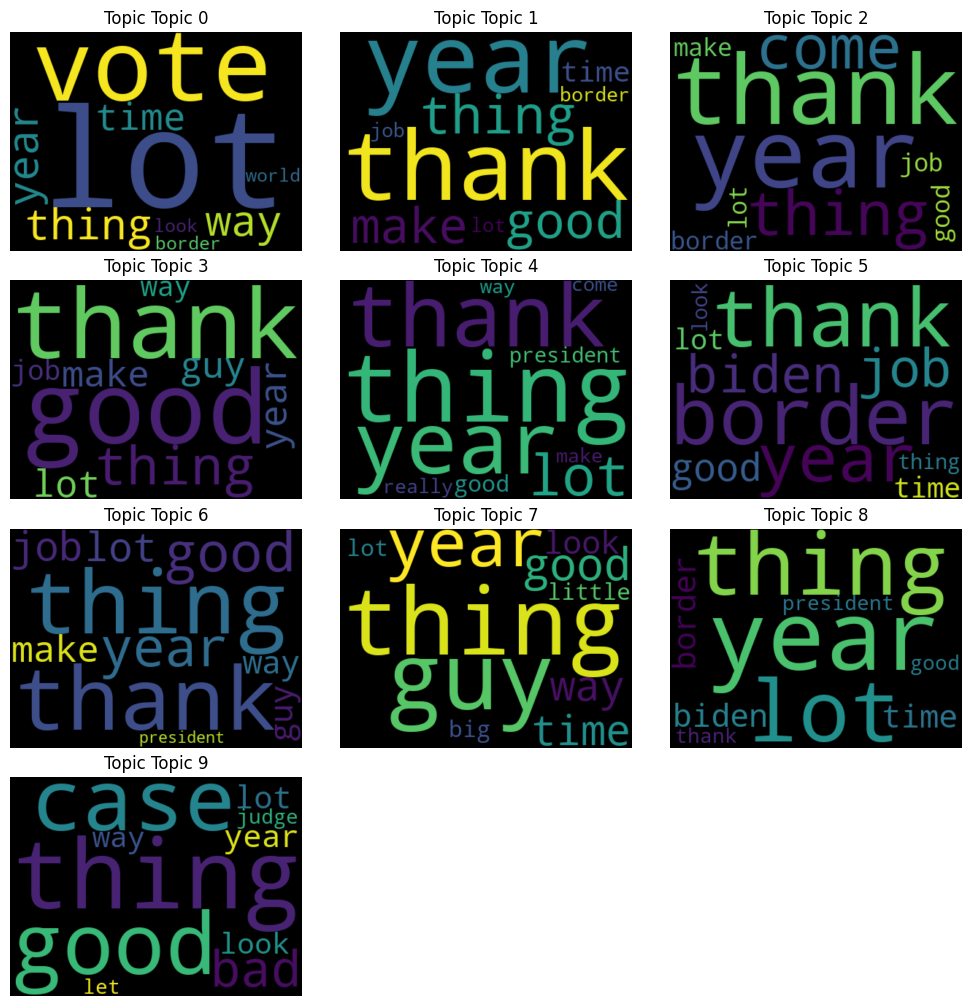

In [71]:
plot_word_clouds_subplots(topic_keywords)

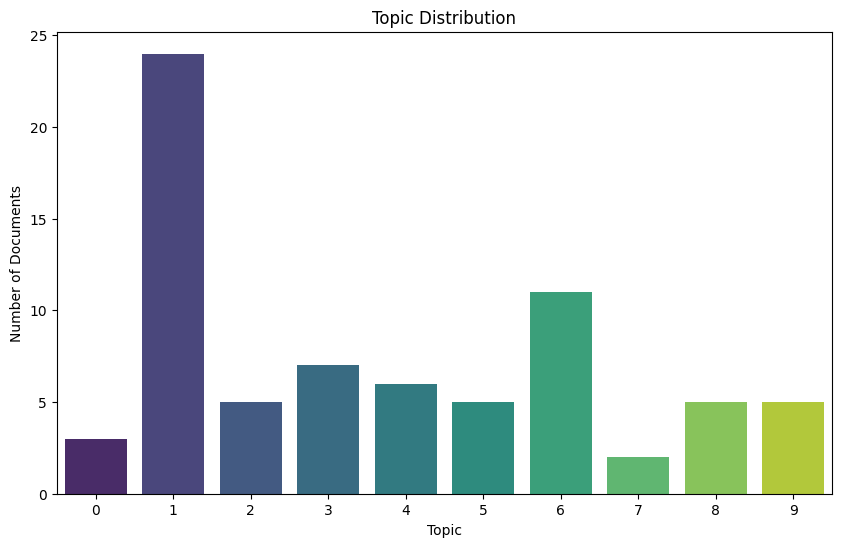

In [72]:
# Plot topic distribution
def plot_topic_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='topic', data=df, palette='viridis')
    plt.title('Topic Distribution')
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.show()

plot_topic_distribution(df)

# Network Graphs

In [76]:
df1 = df.copy() 
df1['len'] = df['processed_speech'].apply(lambda x: len(x))
df1 = df1.sort_values(by = ['len']).reset_index(drop = True)

In [30]:
# preprocess Text
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words

# extract Relationships (Co-occurrence of Words)
def extract_relationships(speeches):
    relationships = []
    for speech in speeches:
        words = preprocess_text(speech)
        relationships.extend(combinations(set(words), 2))  # Create word pairs
    return relationships

relationships = extract_relationships(df1.loc[[0, 72], 'speech'])

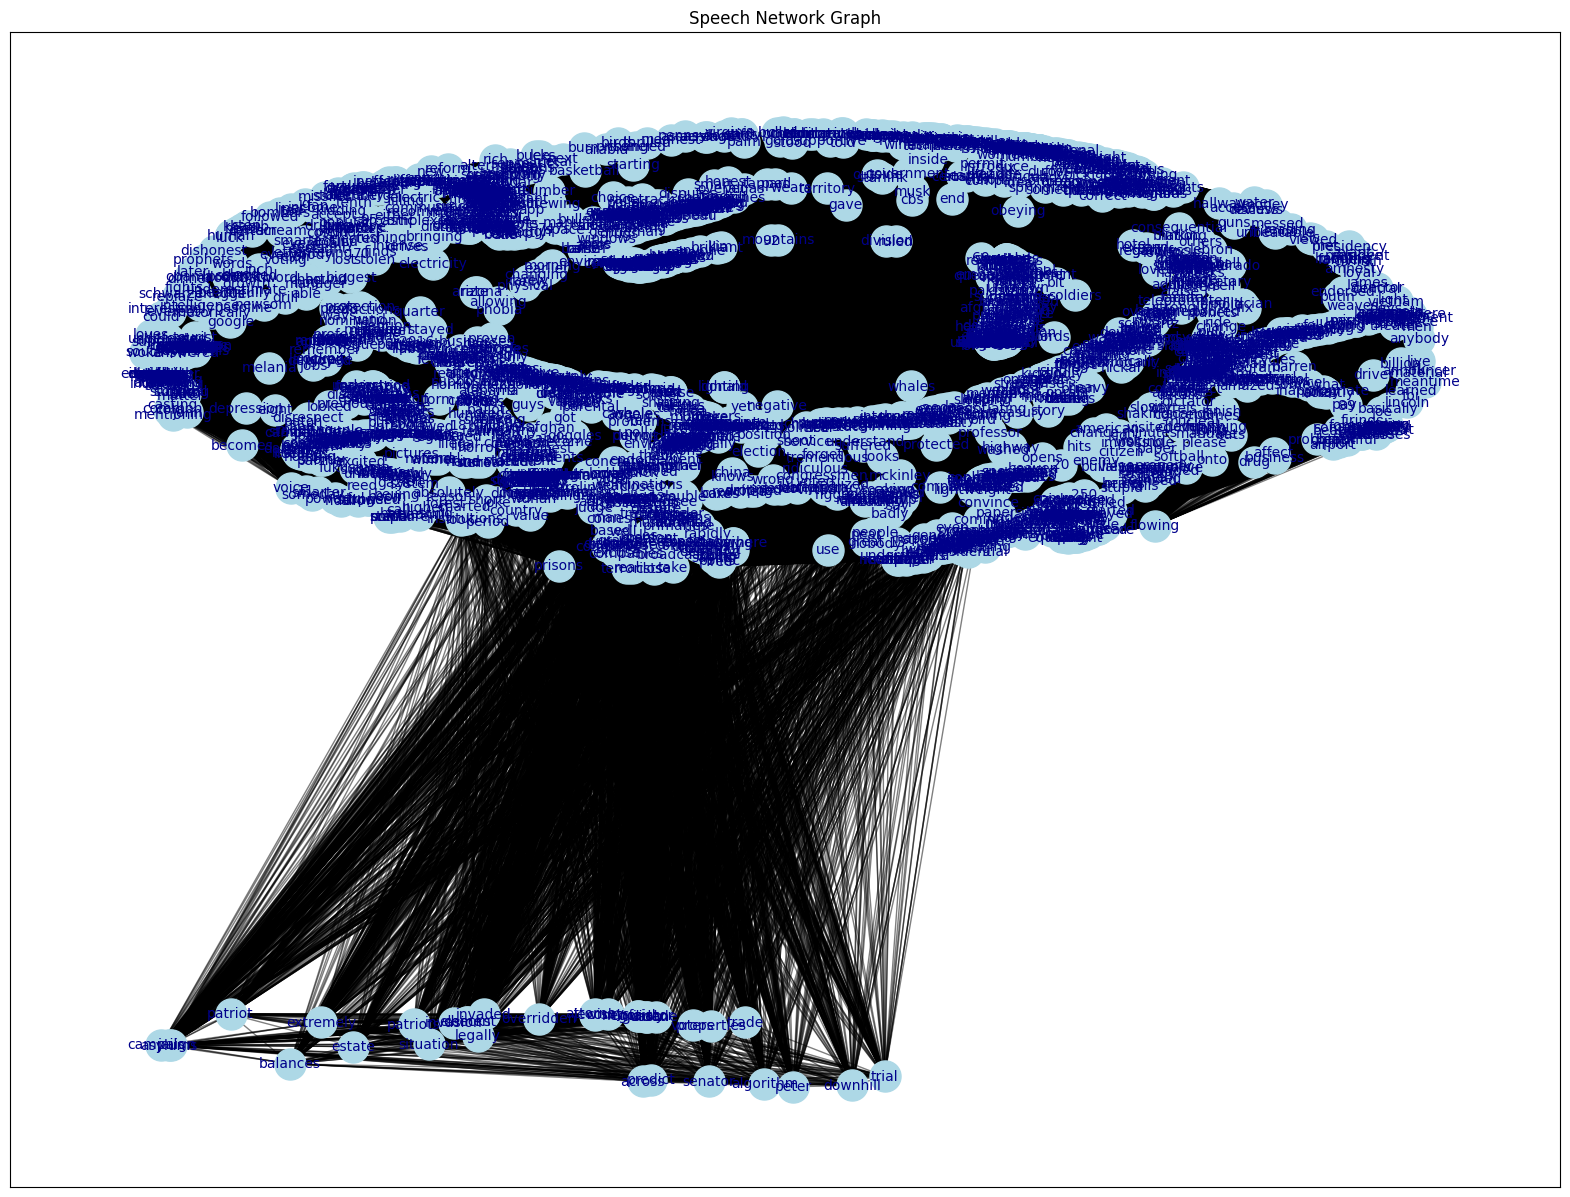

In [31]:
# build the Network Graph
G = nx.Graph()
G.add_edges_from(relationships)

# visualize the Graph
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, seed=42)  # Set a layout for better visualization
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="darkblue")
plt.title("Speech Network Graph")
plt.show()

## Build Interactive python Sigma library

In [91]:
def preprocess_text(text):
    words = text.split()
    return [word for word in words if len(word) > 1 and re.match(r'^[a-zA-Z0-9]+$', word)]

df1['processed_speech_1'] = df1['processed_speech'].apply(preprocess_text)

relationships_1 = []
for words in df1['processed_speech_1'].loc[0:1]:
    relationships_1.extend(combinations(set(words), 2))  # Pair unique words in each speech

G = nx.Graph()
G.add_edges_from(relationships_1)

word_locations = {}
for index, row in df1.loc[0:1].iterrows():
    for word in row['processed_speech_1']:
        word_locations[word] = word_locations.get(word, 0) + 1

nx.set_node_attributes(G, word_locations, 'frequency')
nx.set_node_attributes(G, {node: node for node in G.nodes()}, 'label')  # Set labels explicitly

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# ipysigma for visualization
sigma_graph = Sigma(
    G,
    node_color="frequency",  
    node_size="degree",  
    node_label="label",  
    node_label_size="degree", 
    default_node_label=False,
)


sigma_graph


Sigma(nx.Graph with 309 nodes and 30,948 edges)

Bby using network graphs we can see more clearly what his intentions are after his election and which topics he put more pressure on. This visualization helps in understanding the relationships and co-occurrences of words in his speeches, providing insights into the key themes and focus areas of his campaign.

In [54]:
# Sigma.write_html(
#     G,
#     'speech_network.html',
#     fullscreen=True,
#     node_metrics=['louvain'],
#     node_color='degree',
#     node_size='degree',
#     default_node_label=True
# )

In [92]:

relationships_1 = []
for words in df1['processed_speech_1'].iloc[[0, 6]]:
    relationships_1.extend(combinations(set(words), 2))  # Pair unique words in each speech

G = nx.Graph()
G.add_edges_from(relationships_1)

word_locations = {}
for index, row in df1.iloc[[0, 6]].iterrows():
    for word in row['processed_speech_1']:
        word_locations[word] = word_locations.get(word, 0) + 1

nx.set_node_attributes(G, word_locations, 'frequency')
nx.set_node_attributes(G, {node: node for node in G.nodes()}, 'label')  # Set labels explicitly

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# ipysigma for visualization
sigma_graph = Sigma(
    G,
    node_color="frequency",  
    node_size="degree",  
    node_label="label",  
    node_label_size="degree", 
    default_node_label=False  
)


sigma_graph

Sigma(nx.Graph with 692 nodes and 203,806 edges)